# UCI regression eval

In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "E-ANN-1": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold", # TODO: make more o-paco
    "OGD": "blueviolet",
    "O-EKF": "darkorange",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path_base = "./results"
# experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error" not in f)]
experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error10" in f)]
sorted(experiment_names)

['bostonHousing-target-p-error10.pkl',
 'concrete-target-p-error10.pkl',
 'energy-target-p-error10.pkl',
 'kin8nm-target-p-error10.pkl',
 'naval-propulsion-plant-target-p-error10.pkl',
 'power-plant-target-p-error10.pkl',
 'protein-tertiary-structure-target-p-error10.pkl',
 'wine-quality-red-target-p-error10.pkl',
 'yacht-target-p-error10.pkl']

In [4]:
df_results_all = []
for file_name in experiment_names:
    dataset = file_name.replace("-target.pkl", "")
    path = os.path.join(path_base, file_name)
    with open(path, "rb") as f:
        experiment = pickle.load(f)

    errors = experiment["methods"]

    df_results = pd.DataFrame({
        name: errors[name].median(axis=0)
        for name in errors
    })

    df_results = df_results.melt()
    df_results["dataset"] = dataset
    df_results_all.append(df_results)

df_results_all = pd.concat(df_results_all, axis=0)

# Root median squared error
df_results_all["value"] = np.sqrt(df_results_all["value"])
df_results_all["dataset"] = df_results_all["dataset"].str.replace("-.*", "", regex=True).str.capitalize()

In [15]:
def format_entry(entry):
    entry = entry[entry < 1000]
    mean = entry.mean()
    std = entry.std()
    if std > 1000:
        label = rf"$-$"
    else:
        label = rf"${mean:0.2f} \pm {std:0.2f}$"
    return label

In [16]:
res = (
    df_results_all
    .pivot_table(columns="variable", index="dataset", values="value", aggfunc=format_entry)
)
res

variable,E-ANN-1,EKF,O-EKF,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,$0.06 \pm 0.01$,$1.56 \pm 0.53$,$0.07 \pm 0.01$,$0.80 \pm 0.42$,$0.08 \pm 0.01$,$0.07 \pm 0.01$
Concrete,$1.33 \pm 6.96$,$1.15 \pm 0.36$,$0.10 \pm 0.01$,$0.50 \pm 0.15$,$0.10 \pm 0.01$,$0.09 \pm 0.01$
Energy,$0.04 \pm 0.00$,$2.64 \pm 0.70$,$0.04 \pm 0.00$,$0.57 \pm 0.21$,$0.05 \pm 0.00$,$0.04 \pm 0.00$
Kin8nm,$0.10 \pm 0.02$,$0.78 \pm 0.19$,$0.09 \pm 0.00$,$0.43 \pm 0.09$,$0.10 \pm 0.00$,$0.09 \pm 0.00$
Naval,$1.20 \pm 7.01$,$0.95 \pm 0.21$,$0.13 \pm 0.01$,$0.38 \pm 0.06$,$0.18 \pm 0.01$,$0.12 \pm 0.01$
Power,$0.06 \pm 0.02$,$0.59 \pm 0.12$,$0.05 \pm 0.00$,$0.38 \pm 0.07$,$0.05 \pm 0.00$,$0.05 \pm 0.00$
Protein,$0.22 \pm 0.01$,$0.49 \pm 0.08$,$0.19 \pm 0.00$,$0.33 \pm 0.03$,$0.20 \pm 0.00$,$0.19 \pm 0.00$
Wine,$11.54 \pm 76.53$,$0.97 \pm 0.33$,$0.11 \pm 0.01$,$0.87 \pm 0.33$,$0.11 \pm 0.01$,$0.11 \pm 0.01$
Yacht,$0.11 \pm 0.02$,$1.60 \pm 0.59$,$0.13 \pm 0.02$,$1.22 \pm 0.45$,$0.13 \pm 0.02$,$0.12 \pm 0.02$


In [18]:
print(res.style.to_latex(hrules=True).replace("_", "-"))

\begin{tabular}{lllllll}
\toprule
variable & E-ANN-1 & EKF & O-EKF & OGD & WLF-IMQ & WLF-MD \\
dataset &  &  &  &  &  &  \\
\midrule
Bostonhousing & $0.06 \pm 0.01$ & $1.56 \pm 0.53$ & $0.07 \pm 0.01$ & $0.80 \pm 0.42$ & $0.08 \pm 0.01$ & $0.07 \pm 0.01$ \\
Concrete & $1.33 \pm 6.96$ & $1.15 \pm 0.36$ & $0.10 \pm 0.01$ & $0.50 \pm 0.15$ & $0.10 \pm 0.01$ & $0.09 \pm 0.01$ \\
Energy & $0.04 \pm 0.00$ & $2.64 \pm 0.70$ & $0.04 \pm 0.00$ & $0.57 \pm 0.21$ & $0.05 \pm 0.00$ & $0.04 \pm 0.00$ \\
Kin8nm & $0.10 \pm 0.02$ & $0.78 \pm 0.19$ & $0.09 \pm 0.00$ & $0.43 \pm 0.09$ & $0.10 \pm 0.00$ & $0.09 \pm 0.00$ \\
Naval & $1.20 \pm 7.01$ & $0.95 \pm 0.21$ & $0.13 \pm 0.01$ & $0.38 \pm 0.06$ & $0.18 \pm 0.01$ & $0.12 \pm 0.01$ \\
Power & $0.06 \pm 0.02$ & $0.59 \pm 0.12$ & $0.05 \pm 0.00$ & $0.38 \pm 0.07$ & $0.05 \pm 0.00$ & $0.05 \pm 0.00$ \\
Protein & $0.22 \pm 0.01$ & $0.49 \pm 0.08$ & $0.19 \pm 0.00$ & $0.33 \pm 0.03$ & $0.20 \pm 0.00$ & $0.19 \pm 0.00$ \\
Wine & $11.54 \pm 76.53$ & $0.97 

In [8]:
(
    df_results_all
    .pivot_table(columns="variable", index="dataset", values="value", aggfunc=lambda x: (x > 1000).sum())
)

variable,E-ANN-1,EKF,O-EKF,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,0,0,0,0,0,0
Concrete,5,0,0,0,0,0
Energy,0,0,0,0,0,0
Kin8nm,1,0,0,0,0,0
Naval,0,0,0,0,0,0
Power,1,0,0,0,0,0
Protein,0,0,0,0,0,0
Wine,8,0,0,0,0,0
Yacht,0,0,0,0,0,0


## Experiments

In [9]:
sorted(experiment_names)

['bostonHousing-target-p-error10.pkl',
 'concrete-target-p-error10.pkl',
 'energy-target-p-error10.pkl',
 'kin8nm-target-p-error10.pkl',
 'naval-propulsion-plant-target-p-error10.pkl',
 'power-plant-target-p-error10.pkl',
 'protein-tertiary-structure-target-p-error10.pkl',
 'wine-quality-red-target-p-error10.pkl',
 'yacht-target-p-error10.pkl']

In [10]:
targets = [
    "concrete-target-p-error10.pkl",
    "kin8nm-target-p-error10.pkl",
    "naval-propulsion-plant-target-p-error10.pkl",
    "yacht-target-p-error10.pkl",
]

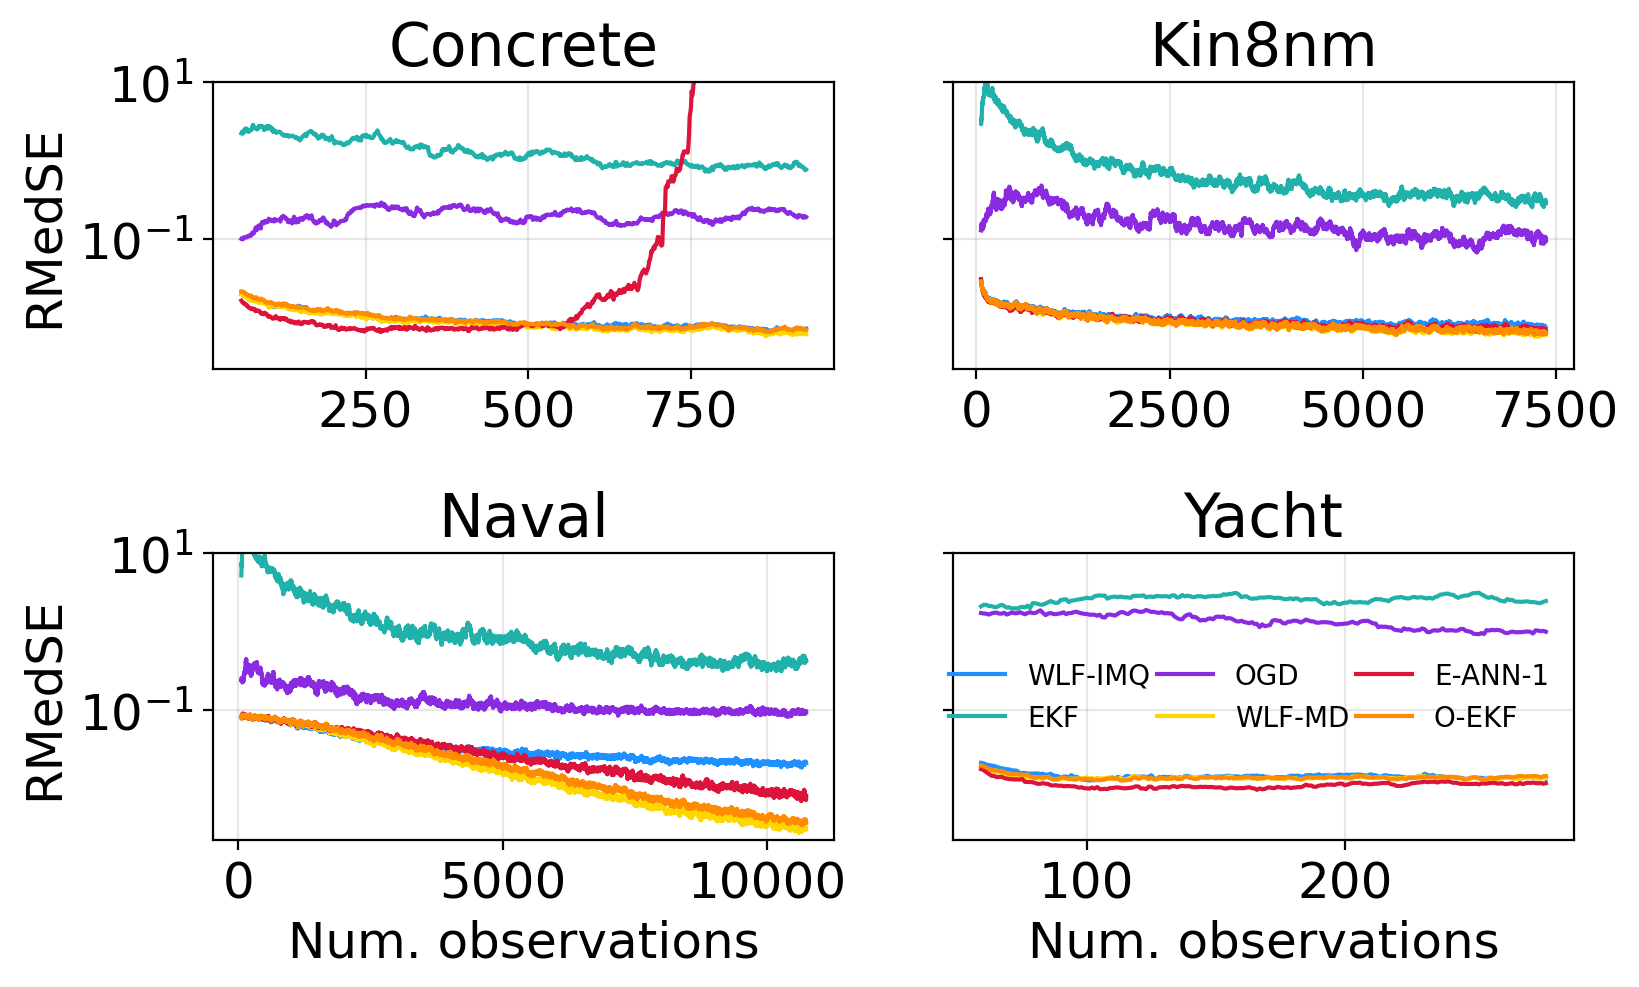

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(6.4 * 1.3, 4.8 * 1.1), sharey=True)
for ax, file_name in zip(axs.ravel(), targets):
    dataset = file_name.replace("-target-p-error10.pkl", "")
    path = os.path.join(path_base, file_name)
    with open(path, "rb") as f:
        experiment = pickle.load(f)

    errors = experiment["methods"]

    for method in errors:
        errors[method][10:].rolling(50).median().median(axis=1).plot(label=method, c=cmap[method], ax=ax)
    ax.set_yscale("log")
    ax.grid(alpha=0.3)
    ax.set_title(re.sub("-.*", "", dataset).capitalize())
    ax.set_ylim(top=10 ** 1)
plt.subplots_adjust(
    hspace=0.6
)
axs[1, 1].legend(ncol=3, fontsize=10, columnspacing=0.25, fancybox=False, frameon=False, alignment="left")
axs[0, 0].set_ylabel("RMedSE")
axs[1, 0].set_ylabel("RMedSE")
axs[1, 0].set_xlabel("Num. observations")
axs[1, 1].set_xlabel("Num. observations")
plt.tight_layout()
plt.savefig("./figures/uci-dataset-training-error.pdf")